In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

In [2]:
df = pd.read_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8_narrative_elbow_updated.parquet", engine="fastparquet")

# Stance-by-Quartile Analysis of Parliamentary Clubs (8th Term)

## Overview
This notebook evaluates whether **embedding models** capture **stance** in Slovak parliamentary speeches from the **8th electoral term** by examining how **club (party) composition** changes across **similarity-score quartiles** **above a model-specific semantic threshold**.

> **Research question:** If an embedding model encodes stance (not only topic), do we observe systematic shifts in the **proportion of selected clubs** as we move from **lower** to **higher** similarity quartiles?

---

## Data & Inputs
- **Source file:** `../data/df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8_narrative_elbow_updated.parquet` (loaded with `fastparquet`).
- **Key columns (schema excerpts):**
  - `klub`: parliamentary club label.
  - For each `model × narrative`:
    - `<model>_<narrative>_cosine_score`
    - `<model>_<narrative>_pwlf_above_threshold` ∈ {0, 1}

> **PWLF threshold:** The boolean column `_pwlf_above_threshold` encodes whether a speech is above a **piecewise linear fit (PWLF)**-derived elbow/knee threshold (precomputed upstream).

---

## Models & Narratives
- **Embedding models** analyzed:
  - `openAI_embedding_3076`
  - `openAI_embedding_small`
  - `gemini-embedding-exp-03-07`
  - `mistral_embedings`
  - `voyage-3-large_embeddings`
- **Narratives** analyzed:
  - `vaccine_similarity`
  - `russian_similarity`
  - `gender_similarity`

---

## Methodology

All narratives are present in the **8th electoral term**, yet parliamentary clubs exhibit heterogeneous stances. We test whether models capture stance by comparing **club composition** among:
1) speeches **above the model-specific threshold**, and  
2) the **quartiles (Q1–Q4)** of similarity **within** that above-threshold set,  
to the **overall** club distribution in the term.

### Procedure (per `model × narrative`)
1. **Filter** speeches to those with `<model>_<narrative>_pwlf_above_threshold == 1`.  
2. **Drop** rows with missing `<model>_<narrative>_cosine_score` or `klub`.  
3. **Compute quartiles** at the 25th, 50th, and 75th percentiles of the **cosine score** **within the above-threshold set**.  
4. **Assign quartile labels** to each speech:  
   - Q1 (Lowest 25%), Q2 (25–50%), Q3 (50–75%), Q4 (Highest 25%).  
5. **Tabulate distributions**:  
   - **Overall distribution**: `value_counts(normalize=True)` for `klub` in the above-threshold set.  
   - **Quartile distributions**: `value_counts(normalize=True)` within each quartile.  
6. **Store results** in a nested dictionary `all_results[model][narrative]` with:
   - `quartiles` (boundaries),  
   - `distributions` (per quartile),  
   - `overall_distribution`,  
   - `total_count`,  
   - `quartile_counts`.

---

## Target Clubs & Proportion Benchmarks
Two reference groups are defined for plotting and interpretation:

- **Group A:** `['LSNS', 'Republika']`  
- **Group B:** `['LSNS', 'Republika', 'SMER-SD']`

From the **full dataset**, the code computes:
- `proportion_LSNS_Republika_8`  
- `proportion_LSNS_Republika_SMER_8`

> These serve as **horizontal reference lines** in the charts, indicating the **overall share** of the selected clubs in the 8th term.



---

## Visualization
For each **narrative**, the notebook plots the **sum of proportions** for the selected clubs across quartiles **for each model**, adding **reference lines** for overall proportions:

- **X-axis:** Quartiles (Q1 → Q4)  
- **Y-axis:** Sum of club proportions (bounded to [0, 0.6] for visibility)  
- **Lines:** One per embedding model  
- **Reference l**





In [3]:


# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Identify embedding models and narratives from column names
embedding_models = ['openAI_embedding_3076', 'openAI_embedding_small', 'gemini-embedding-exp-03-07', 
                   'mistral_embedings', 'voyage-3-large_embeddings']
narratives = ['vaccine_similarity', 'russian_similarity', 'gender_similarity']

print("🔍 KLUB DISTRIBUTION ANALYSIS BY SIMILARITY SCORE QUARTILES")
print("📍 ANALYZING ONLY SPEECHES ABOVE PWLF THRESHOLD")
print("="*70)
print(f"Analyzing {len(embedding_models)} models × {len(narratives)} narratives")
print(f"Total dataset size: {len(df):,} speeches")
print()

# Function to analyze quartile distributions
def analyze_quartile_distribution(df, model, narrative):
    """
    Analyze klub distribution across quartiles of similarity scores
    ONLY for speeches above PWLF threshold
    """
    score_col = f"{model}_{narrative}_cosine_score"
    threshold_col = f"{model}_{narrative}_pwlf_above_threshold"
    
    if score_col not in df.columns or threshold_col not in df.columns:
        return None
    
    # Filter for speeches ABOVE PWLF threshold only
    above_threshold = df[df[threshold_col] == 1]
    
    if len(above_threshold) == 0:
        return None
    
    # Remove NaN values from the filtered data
    valid_data = above_threshold[[score_col, 'klub']].dropna()
    
    if len(valid_data) == 0:
        return None
    
    # Calculate quartiles
    quartiles = np.percentile(valid_data[score_col], [25, 50, 75])
    
    # Create quartile labels
    def assign_quartile(score):
        if score <= quartiles[0]:
            return 'Q1 (Lowest 25%)'
        elif score <= quartiles[1]:
            return 'Q2 (25-50%)'
        elif score <= quartiles[2]:
            return 'Q3 (50-75%)'
        else:
            return 'Q4 (Highest 25%)'
    
    valid_data = valid_data.copy()
    valid_data['quartile'] = valid_data[score_col].apply(assign_quartile)
    
    # Calculate klub distribution for each quartile
    quartile_distributions = {}
    overall_distribution = valid_data['klub'].value_counts(normalize=True)
    
    for quartile in ['Q1 (Lowest 25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (Highest 25%)']:
        quartile_data = valid_data[valid_data['quartile'] == quartile]
        if len(quartile_data) > 0:
            quartile_dist = quartile_data['klub'].value_counts(normalize=True)
            quartile_distributions[quartile] = quartile_dist
    
    return {
        'quartiles': quartiles,
        'distributions': quartile_distributions,
        'overall_distribution': overall_distribution,
        'total_count': len(valid_data),
        'quartile_counts': valid_data['quartile'].value_counts()
    }

# Store results for all analyses
all_results = {}

# Perform analysis for each model-narrative combination
for model in embedding_models:
    all_results[model] = {}
    for narrative in narratives:
        print(f"📊 Analyzing {model} - {narrative}")
        result = analyze_quartile_distribution(df, model, narrative)
        
        if result:
            all_results[model][narrative] = result
            print(f"   ✓ Above threshold speeches: {result['total_count']:,}")
            print(f"   ✓ Quartile boundaries: {result['quartiles']}")
        else:
            print(f"   ❌ No speeches above threshold")
        print()

print("Analysis completed! Results stored in 'all_results' dictionary.")

🔍 KLUB DISTRIBUTION ANALYSIS BY SIMILARITY SCORE QUARTILES
📍 ANALYZING ONLY SPEECHES ABOVE PWLF THRESHOLD
Analyzing 5 models × 3 narratives
Total dataset size: 19,927 speeches

📊 Analyzing openAI_embedding_3076 - vaccine_similarity
   ✓ Above threshold speeches: 365
   ✓ Quartile boundaries: [0.49118296 0.51029511 0.53203236]

📊 Analyzing openAI_embedding_3076 - russian_similarity
   ✓ Above threshold speeches: 584
   ✓ Quartile boundaries: [0.43771282 0.46767919 0.51404925]

📊 Analyzing openAI_embedding_3076 - gender_similarity
   ✓ Above threshold speeches: 458
   ✓ Quartile boundaries: [0.46088123 0.4796342  0.51521792]

📊 Analyzing openAI_embedding_small - vaccine_similarity
   ✓ Above threshold speeches: 820
   ✓ Quartile boundaries: [0.45085585 0.47622631 0.518913  ]

📊 Analyzing openAI_embedding_small - russian_similarity
   ✓ Above threshold speeches: 443
   ✓ Quartile boundaries: [0.51777899 0.54292152 0.57419162]

📊 Analyzing openAI_embedding_small - gender_similarity
   ✓ Ab

In [11]:
# Define target parties
target_klubs_1 = ['LSNS', 'Republika']
target_klubs_2 = ['LSNS', 'Republika', 'SMER-SD']

# Calculate proportions
proportion_LSNS_Republika_8 = df['klub'].isin(target_klubs_1).mean()
proportion_LSNS_Republika_SMER_8 = df['klub'].isin(target_klubs_2).mean()

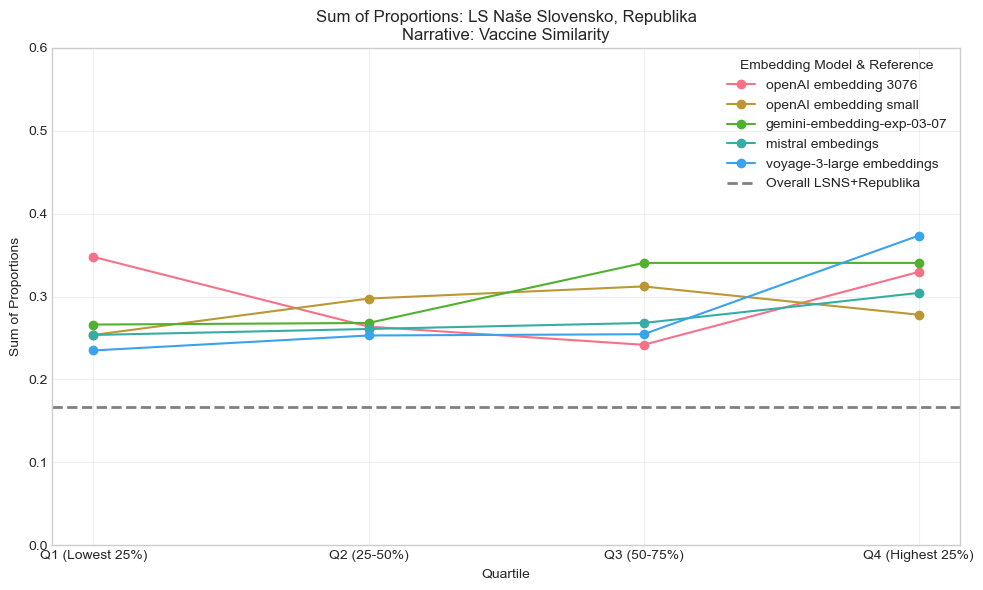

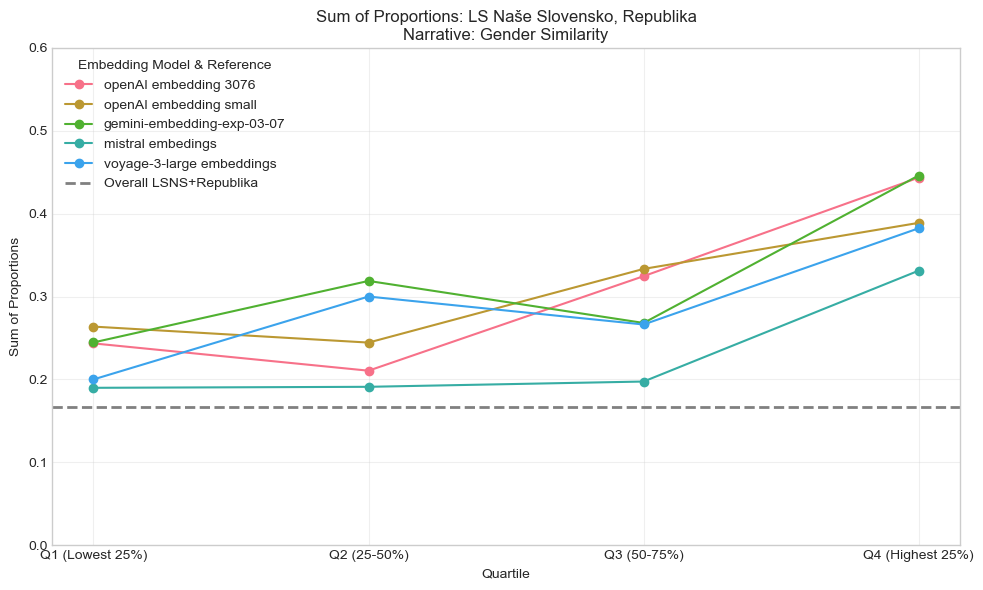

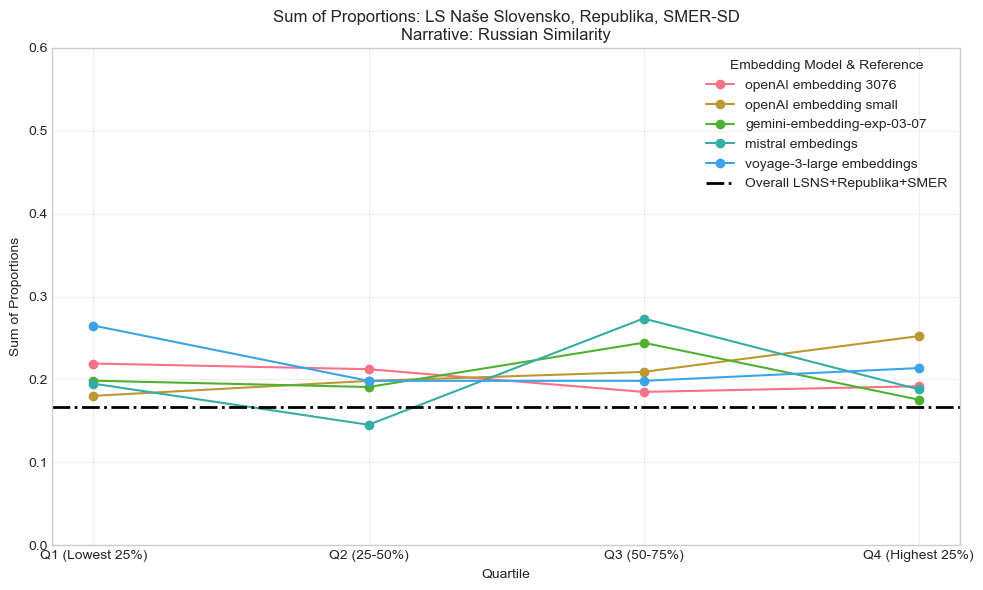

In [ ]:
# Line plot: Sum of proportions for selected clubs across quartiles
# Y axis zoomed to 0-0.6, with reference lines for overall proportions

def plot_selected_club_proportions(all_results, selected_clubs_by_narrative):
    

    quartiles_order = ['Q1 (Lowest 25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (Highest 25%)']

    # Get overall proportions for reference lines
    global proportion_LSNS_Republika_8, proportion_LSNS_Republika_SMER_8

    for narrative, selected_clubs in selected_clubs_by_narrative.items():
        plt.figure(figsize=(10, 6))
        for model in embedding_models:
            if model in all_results and narrative in all_results[model]:
                result = all_results[model][narrative]
                proportions = []
                for quartile in quartiles_order:
                    q_dist = result['distributions'].get(quartile, pd.Series())
                    # Sum proportions for selected clubs
                    sum_prop = sum(q_dist.get(club, 0) for club in selected_clubs)
                    proportions.append(sum_prop)
                plt.plot(quartiles_order, proportions, marker='o', label=model.replace('_', ' '))
        # Add reference lines
        if set(selected_clubs) == set(['LS Naše Slovensko', 'Republika']):
            plt.axhline(proportion_LSNS_Republika_8, color='gray', linestyle='--', linewidth=2, label='Overall LSNS+Republika')
        if set(selected_clubs) == set(['LS Naše Slovensko', 'Republika', 'SMER-SD']):
            plt.axhline(proportion_LSNS_Republika_SMER_8, color='black', linestyle='-.', linewidth=2, label='Overall LSNS+Republika+SMER')
        plt.title(f"Sum of Proportions: {', '.join(selected_clubs)}\nNarrative: {narrative.replace('_', ' ').title()}")
        plt.xlabel("Quartile")
        plt.ylabel("Sum of Proportions")
        plt.ylim(0, 0.6)
        plt.legend(title="Embedding Model & Reference")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(rf"..\graphs\stance_embeddings_club_{narrative}.png")
        plt.show()

# Define selected clubs for each narrative
selected_clubs_by_narrative = {
    'vaccine_similarity': ['LS Naše Slovensko', 'Republika'],
    'gender_similarity': ['LS Naše Slovensko', 'Republika'],
    'russian_similarity': ['LS Naše Slovensko', 'Republika', 'SMER-SD']
}

plot_selected_club_proportions(all_results, selected_clubs_by_narrative)
